<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sampling-1000-from-20000-Ti-H-M3GNet-MD-structures" data-toc-modified-id="Sampling-1000-from-20000-Ti-H-M3GNet-MD-structures-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sampling 1000 from 20000 Ti-H M3GNet MD structures</a></span><ul class="toc-item"><li><span><a href="#load-structures" data-toc-modified-id="load-structures-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>load structures</a></span></li><li><span><a href="#DIRECT-sampling" data-toc-modified-id="DIRECT-sampling-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>DIRECT sampling</a></span></li><li><span><a href="#Manual-sampling-with-fixed-time-interval-of-10-fs" data-toc-modified-id="Manual-sampling-with-fixed-time-interval-of-10-fs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Manual sampling with fixed time interval of 10 fs</a></span></li><li><span><a href="#Feature-coverage-score" data-toc-modified-id="Feature-coverage-score-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Feature coverage score</a></span></li></ul></li><li><span><a href="#Sample-954-structures-from-274,000-M3GNet-MD-structures" data-toc-modified-id="Sample-954-structures-from-274,000-M3GNet-MD-structures-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sample 954 structures from 274,000 M3GNet MD structures</a></span><ul class="toc-item"><li><span><a href="#load-pre-processed-features" data-toc-modified-id="load-pre-processed-features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>load pre-processed features</a></span></li><li><span><a href="#DIRECT-sampling" data-toc-modified-id="DIRECT-sampling-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DIRECT sampling</a></span></li><li><span><a href="#Manual-selection-of-954-structures-with-fixed-selection-interval" data-toc-modified-id="Manual-selection-of-954-structures-with-fixed-selection-interval-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Manual selection of 954 structures with fixed selection interval</a></span></li><li><span><a href="#Coverage-score-for-the-first-7-PCs" data-toc-modified-id="Coverage-score-for-the-first-7-PCs-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Coverage score for the first 7 PCs</a></span></li></ul></li></ul></div>

In [1]:
from maml.sampling.direct import DIRECTSampler, BirchClustering, SelectKFromClusters, M3GNetStructure
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Sampling 1000 from 20000 Ti-H M3GNet MD structures

The required files (10p.traj and M3GNet_features_TiH_274000.pickle) can be downloaded at: https://figshare.com/articles/dataset/20230723_figshare_DIRECT_zip/23734134

## load structures

In [2]:
from ase.io.trajectory import Trajectory
from pymatgen.io.ase import AseAtomsAdaptor

def load_ase_MD_traj(filename:str):
    """
    Load .traj to pymatgen structures
    """
    traj = Trajectory(filename)
    structures = [AseAtomsAdaptor.get_structure(tra) for tra in traj]
    return structures

In [3]:
%%time
structures_20k_MD = load_ase_MD_traj("10ps.traj")

CPU times: user 21.4 s, sys: 600 ms, total: 22 s
Wall time: 7.45 s


## DIRECT sampling

In [4]:
%%time
DIRECT_sampler = DIRECTSampler(clustering=BirchClustering(n=1000, threshold_init=0.05), 
                               select_k_from_clusters=SelectKFromClusters(k=1))

CPU times: user 2.39 s, sys: 332 ms, total: 2.73 s
Wall time: 2.98 s


In [5]:
%%time
DIRECT_selection = DIRECT_sampler.fit_transform(structures_20k_MD)

INFO:maml.sampling.pca:Selected first 8 PCs, explaining 97.66% variance
INFO:maml.sampling.clustering:Birch threshold of 0.05 gives 5769 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 1000 configurations.


CPU times: user 13min 31s, sys: 2min 44s, total: 16min 15s
Wall time: 9min 27s


The vast majority of time of the 10 minutes was used to process structure features of the 20k structures. <font color="red">For large structure set with millions of structures, we thereby suggest pre-process the structures with M3GNetStructure().transform() in parallel processes.</font> The examples of sampling 954 from 274k Ti-H structures and sampling 185k structures from 1.3 million structures in MPF.2021.2.8.all both are based on pre-processed M3GNet features.

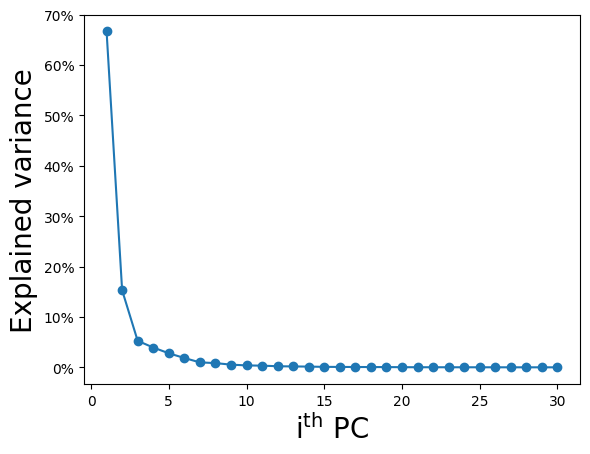

In [6]:
explained_variance = DIRECT_sampler.pca.pca.explained_variance_ratio_
DIRECT_selection['PCAfeatures_unweighted'] = DIRECT_selection['PCAfeatures']/explained_variance[:8]

plt.plot(range(1, 31), explained_variance[:30]*100, "o-",)
plt.xlabel("i$^{\mathrm{th}}$ PC", size=20)
plt.ylabel("Explained variance", size=20)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [7]:
def plot_PCAfeature_coverage(all_features, selected_indexes, method="DIRECT"):
    fig, ax = plt.subplots(figsize=(5, 5))
    selected_features = all_features[selected_indexes]
    plt.plot(all_features[:, 0], all_features[:, 1], "*",alpha=0.5,
                label=f"All {len(all_features):,} structures")
    plt.plot(selected_features[:, 0], selected_features[:, 1],"*", alpha=0.5,
                label=f"{method} sampled {len(selected_features):,}")
    legend = plt.legend(frameon=False, fontsize=14, loc='upper left', bbox_to_anchor=(-0.02,1.02), reverse=True)
    for lh in legend.legendHandles: 
        lh.set_alpha(1)
    plt.ylabel("PC 2", size=20)
    plt.xlabel("PC 1", size=20)

CPU times: user 45.5 ms, sys: 24.8 ms, total: 70.4 ms
Wall time: 9.12 ms


/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_3267/745124701.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


(-18.0, 32.0)

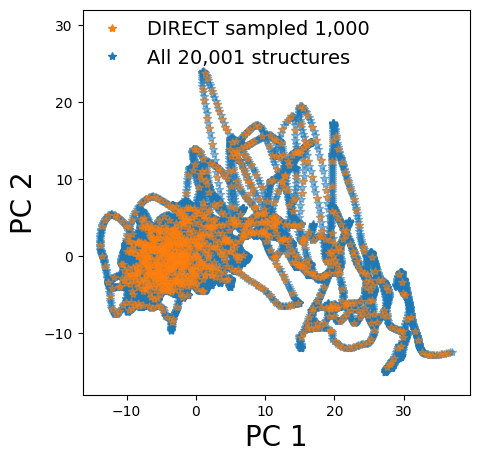

In [8]:
%%time
all_features = DIRECT_selection['PCAfeatures_unweighted']
selected_indexes = DIRECT_selection['selected_indexes']
plot_PCAfeature_coverage(all_features, selected_indexes)
plt.ylim(-18,32)

## Manual sampling with fixed time interval of 10 fs

CPU times: user 24.7 ms, sys: 1.68 ms, total: 26.4 ms
Wall time: 8 ms


/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_3267/745124701.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


(-18.0, 32.0)

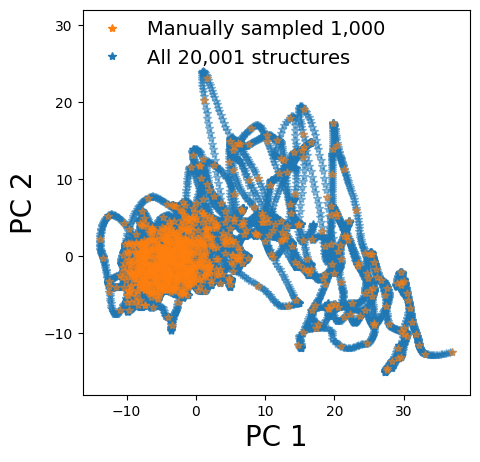

In [9]:
%%time
manual_selection_index = np.arange(0, 20000, 20)
plot_PCAfeature_coverage(all_features, manual_selection_index, "Manually")
plt.ylim(-18,32)

## Feature coverage score

In [10]:
def calculate_feature_coverage_score(all_features, selected_indexes, n_bins=100):
    selected_features = all_features[selected_indexes]
    n_all = np.count_nonzero(np.histogram(all_features, bins=np.linspace(min(all_features), max(all_features), n_bins))[0])
    n_select = np.count_nonzero(np.histogram(selected_features, bins=np.linspace(min(all_features), max(all_features), n_bins))[0])
    return n_select/n_all

In [11]:
def calculate_all_FCS(all_features, selected_indexes, b_bins=100):
    select_scores = [calculate_feature_coverage_score(all_features[:, i], selected_indexes, n_bins=b_bins) \
                     for i in range(all_features.shape[1])]
    return select_scores

In [12]:
%%time
all_features = DIRECT_selection['PCAfeatures_unweighted']
scores_DIRECT = calculate_all_FCS(all_features, DIRECT_selection['selected_indexes'], b_bins=100)
scores_MS = calculate_all_FCS(all_features, manual_selection_index, b_bins=100)

CPU times: user 128 ms, sys: 946 µs, total: 129 ms
Wall time: 44.6 ms


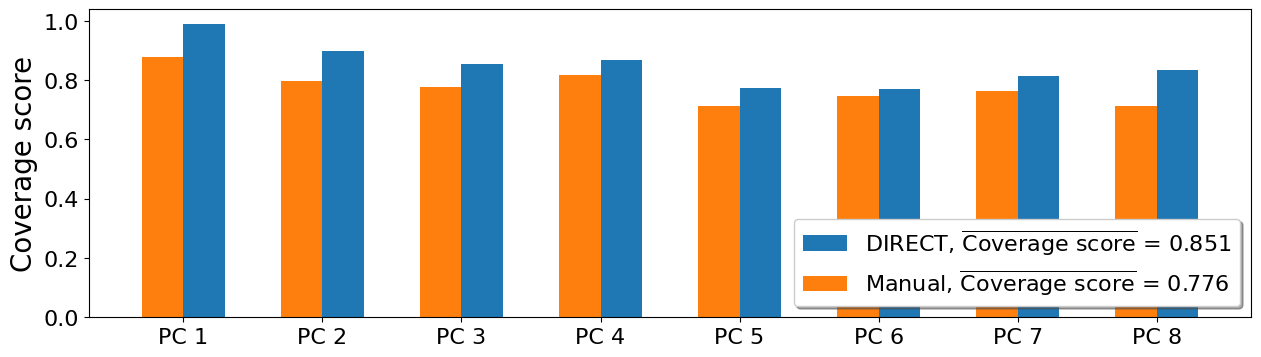

In [13]:
x = np.arange(len(scores_MS))
x_ticks = [f"PC {n+1}" for n in range(len(x))]

plt.figure(figsize=(15,4))
plt.bar(x+0.6, scores_DIRECT, width=0.3, label=f"DIRECT, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_DIRECT):.3f}")
plt.bar(x+0.3, scores_MS, width=0.3, label=f"Manual, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_MS):.3f}")
plt.xticks(x+0.45, x_ticks,size=16)
plt.yticks(np.linspace(0,1.,6),size=16)
plt.ylabel("Coverage score", size=20)
plt.legend(shadow=True, loc="lower right", fontsize=16)

# Sample 954 structures from 274,000 M3GNet MD structures
As in the DIRECT paper, we performed 10-ps M3GNet MD simulations on 274 MD scenarios. From each trajectory of 20k snapshots, we use DIRECT sampling to select 1000 structures, constructing a pool of 274k structures. We then use DIRECT to sample 954 structures from the 274k MD structures as DIRECT training structures.

## load pre-processed features

In [14]:
with open("M3GNet_features_TiH_274000.pickle", 'rb') as f:
    TiH_274000_MD = pickle.load(f)

In [15]:
TiH_274000_MD.keys()

dict_keys(['M3GNet_features'])

## DIRECT sampling

In [16]:
%%time
DIRECT_sampler = DIRECTSampler(structure_encoder=None, 
                               clustering=BirchClustering(n=954, threshold_init=0.1),
                               select_k_from_clusters=SelectKFromClusters(k=1))

CPU times: user 19 µs, sys: 5 µs, total: 24 µs
Wall time: 24.8 µs


In [17]:
%%time
DIRECT_selection = DIRECT_sampler.fit_transform(TiH_274000_MD['M3GNet_features'])

INFO:maml.sampling.pca:Selected first 7 PCs, explaining 98.58% variance
INFO:maml.sampling.clustering:Birch threshold of 0.1 gives 1293 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 954 configurations.


CPU times: user 25.3 s, sys: 1.93 s, total: 27.2 s
Wall time: 7.84 s


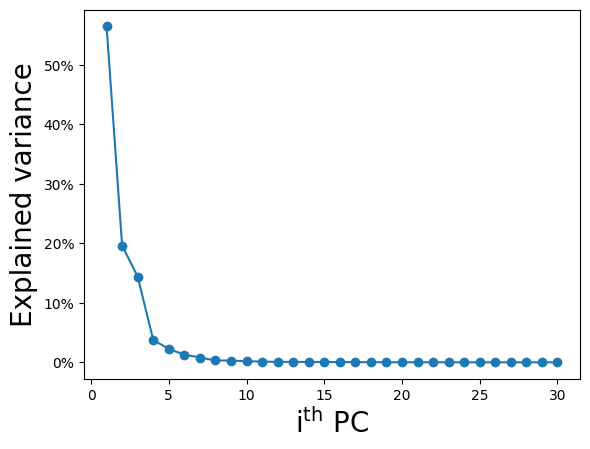

In [18]:
explained_variance = DIRECT_sampler.pca.pca.explained_variance_ratio_
DIRECT_selection['PCAfeatures_unweighted'] = DIRECT_selection['PCAfeatures']/explained_variance[:7]

plt.plot(range(1, 31), explained_variance[:30]*100, "o-",)
plt.xlabel("i$^{\mathrm{th}}$ PC", size=20)
plt.ylabel("Explained variance", size=20)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

CPU times: user 53.8 ms, sys: 32 ms, total: 85.8 ms
Wall time: 13.2 ms


/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_3267/745124701.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


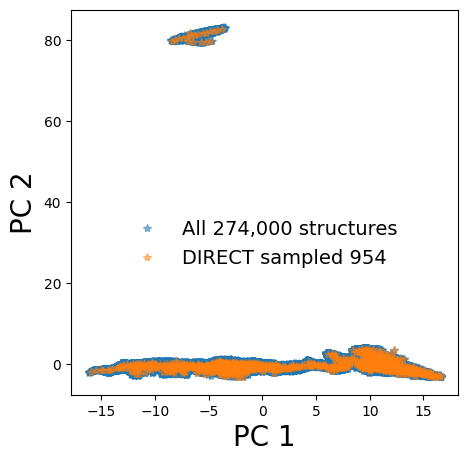

In [19]:
%%time
all_features = DIRECT_selection['PCAfeatures_unweighted']
selected_indexes = DIRECT_selection['selected_indexes']
plot_PCAfeature_coverage(all_features, selected_indexes)
plt.legend(bbox_to_anchor=(0.1,0.5), loc="upper left", fontsize=14, frameon=False)

## Manual selection of 954 structures with fixed selection interval

CPU times: user 33.5 ms, sys: 2.61 ms, total: 36.1 ms
Wall time: 12.7 ms


/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_3267/745124701.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


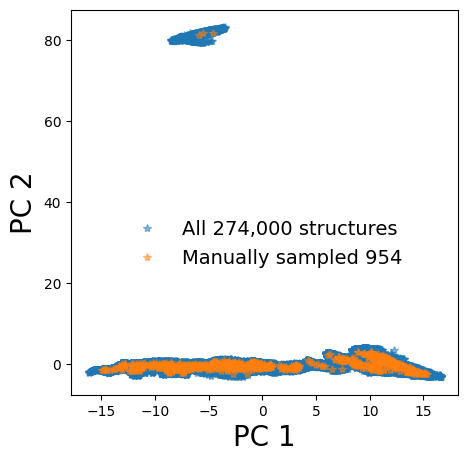

In [20]:
%%time
manual_selection_index = [int(i) for i in np.linspace(0, 274000-1, 954)]
plot_PCAfeature_coverage(all_features, manual_selection_index, "Manually")
plt.legend(bbox_to_anchor=(0.1,0.5), loc="upper left", fontsize=14, frameon=False)

## Coverage score for the first 7 PCs

In [21]:
%%time
all_features = DIRECT_selection['PCAfeatures_unweighted']
scores_TiH_DIRECT_birch = calculate_all_FCS(all_features, DIRECT_selection['selected_indexes'], b_bins=100)
scores_TiH_MS = calculate_all_FCS(all_features, manual_selection_index, b_bins=100)

CPU times: user 558 ms, sys: 2.98 ms, total: 561 ms
Wall time: 537 ms


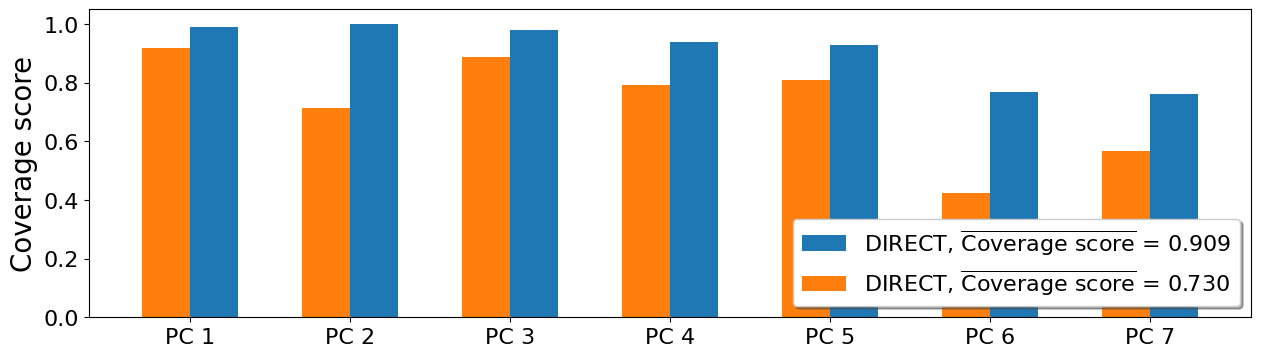

In [22]:
x = np.arange(len(scores_TiH_DIRECT_birch))
x_ticks = [f"PC {n+1}" for n in range(len(x))]

plt.figure(figsize=(15,4))
plt.bar(x+0.6, scores_TiH_DIRECT_birch, width=0.3, label=f"DIRECT, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_TiH_DIRECT_birch):.3f}")
plt.bar(x+0.3, scores_TiH_MS, width=0.3, label=f"DIRECT, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_TiH_MS):.3f}")
plt.xticks(x+0.45, x_ticks,size=16)
plt.yticks(np.linspace(0,1.,6),size=16)
plt.ylabel("Coverage score", size=20)
plt.legend(shadow=True, loc="lower right", fontsize=16)